# J-Quants API Quick Startガイド

In [ ]:
#@title 初期設定＆各種import
#@markdown ←にある▶ボタンを押すとGoogle Colabでコードを実行することができます。

#@markdown まずはこちらのコードを実行し、J-Quants APIを利用するため必要なパッケージをimportしましょう。

import json
import sys
import requests

from IPython.display import display
import pandas as pd

pd.set_option("display.max_columns", None)

API_URL = "https://api.jquants.com"

## Step1：API利用開始までの流れ　※初回のみ実施

J-Quants APIのご利用を検討いただき、ありがとうございます。

**J-Quants APIをご利用いただくには、以下の2つを事前に行っていただく必要がございます。**
 1. [J-Quants Webサイト](https://jpx-jquants.com/)への登録
 2. J-Quants API利用のためのプラン（Free, Light, Standard, Premium）選択

まだ、ご登録もしくはプラン選択がお済みでない方は、まず上記の2項目を行っていただきますようお願いいたします。  
より具体的な手順は[こちら](https://jpx.gitbook.io/j-quants-ja/outline/getstarted)をご参照ください。

##Step2及びStep3：リフレッシュトークン取得 & idToken取得
リフレッシュトークンを取得するには2つの方法があります。
1. J-Quants Webサイトへログインし、リフレッシュトークンを取得するボタンからリフレッシュトークンを取得する方法
2. リフレッシュトークン取得APIを利用し、リフレッシュトークンを取得する方法

以下に記載のどちらかお好みの方法でリフレッシュトークン及びidTokenを取得してください。

In [ ]:
#@title **1.J-Quants Webサイトから取得したリフレッシュトークンを貼り付ける場合**
#@markdown J-Quants Webサイトにて取得したリフレッシュトークンを以下の「ここにtextを挿入」の箇所に貼り付けてください。

refreshtoken = ""#@param {type: "string"}

# idToken取得
res = requests.post(f"{API_URL}/v1/token/auth_refresh?refreshtoken={refreshtoken}")
if res.status_code == 200:
    id_token = res.json()['idToken']
    headers = {'Authorization': 'Bearer {}'.format(id_token)}
    display("idTokenの取得に成功しました。")
else:
    display(res.json()["message"])


#@markdown 上記コードを実行し、**「idTokenの取得に成功しました。」**と表示されれば、J-Quants APIを利用するための準備は完了です。  

#@markdown なお、 「Your refresh token may be incorrect or expired.」等のエラーが出力されている場合は、上記で貼り付けたリフレッシュトークンが誤っているか、期限が切れている可能性がございます。

#@markdown その場合はお手数ですが、再度リフレッシュトークンをJ-Quants Webサイトから取得いただき、再度実行してください。


###**2. J-Quants Webサイトに登録したID及びPWを使用し、RefreshToken及びidTokenをAPIを利用して取得する場合**

In [ ]:
#@title Google Driveのマウント

#@markdown 登録いただいたIDやPWを直接本Notebookに記載するのはセキュリティ上適切ではない可能性があるため、<br>
#@markdown Google Driveに設定ファイルを作成し、当該設定ファイルにIDやPWを記載することをおすすめします。

#@markdown 本コードを実行し、まずはGoogle Driveをマウントします。


from google.colab import drive

try:
    drive.mount('/content/drive')
except:
    print("Google Driveのマウントに失敗しました。")
else:
    print("Google Driveのマウントに成功しました。")

#### 設定ファイルの作成（初回のみ）
- 以下の画像のように 「drive→MyDrive→drive_ws→secret→jquants-api.toml」といった階層で設定ファイルを作成します。

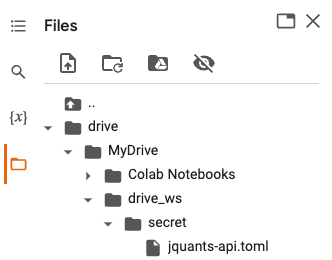

- 作成したtomlファイルに以下のサンプルのとおりID及びパスワードを記載します。  
(なお、\*の箇所はご登録いただいたID及びPWに置き換えてください。)

```
[jquants-api-client]
mailaddress = "*****@***.***"
password = "**************"
```

In [ ]:
#@title 作成した設定ファイルを読み込み、リフレッシュトークン及びidTokenを取得
#@markdown 正しく設定ファイルが作成されていれば、本コードを実行することで、idTokenを取得することができます。
#@markdown 「APIを使用する準備が完了しました。」と出力されれば、されれば、J-Quants APIをコールすることができるようになります！

if sys.version_info >= (3, 11):
    import tomllib
else:
    import tomli as tomllib
    
config_path = ("/content/drive/MyDrive/drive_ws/secret/jquants-api.toml")

with open(config_path, mode="rb") as f:
    ret = tomllib.load(f)["jquants-api-client"]

USER_DATA = {k: v for k, v in ret.items()}

# refresh token取得
try:
  res = requests.post(f"{API_URL}/v1/token/auth_user", data=json.dumps(USER_DATA))
  refresh_token = res.json()['refreshToken']
except:
  print("RefreshTokenの取得に失敗しました。")
else:
  # id token取得
  try:
    res = requests.post(f"{API_URL}/v1/token/auth_refresh?refreshtoken={refresh_token}")
    id_token = res.json()['idToken']
  except:
    print("idTokenの取得に失敗しました。")
  else:
    headers = {'Authorization': 'Bearer {}'.format(id_token)}
    print("API使用の準備が完了しました。")

## Step4：取得したIDトークンを用いて各APIをご利用ください。

### Freeプラン以上のプランで利用できるAPI
- 上場銘柄一覧（/listed/info）
- 株価四本値*（/prices/daily_quotes）
- 財務情報/fins/statements)
- 決算発表予定日（/fins/announcement）

\* プレミアムプランのユーザのみ、前後場の四本値及び取引高・取引代金の情報が取得可能


In [ ]:
#@title 上場銘柄一覧（/listed/info）

#@markdown - 過去時点での銘柄情報、当日の銘柄情報および翌営業日時点の銘柄情報が取得可能です。
#@markdown - データの取得では、銘柄コード（code）または日付（date）の指定が可能です。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の24:00頃


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
query = ""
if code != "":
  query += f'code={code}'
if date != "":
  if code !="":
    query += "&"
  query += f'date={date}'
if query != "":
  query = "?"+query
res = requests.get(f"{API_URL}/v1/listed/info{query}", headers=headers)
if res.status_code == 200:
  data = res.json()["info"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 株価四本値（/prices/daily_quotes）

#@markdown - 株価は分割・併合を考慮した調整済み株価（小数点第２位四捨五入）と調整前の株価を取得することができます。
#@markdown - データの取得では、銘柄コード（code）または日付（date）の指定が必須となります。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の17:00頃

#@markdown - Premiumプランの方には、日通しに加え、前場(Morning)及び後場(Afternoon)の四本値及び取引高（調整前・後両方）・取引代金が取得可能です。


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}
query = ""
if code != "":
  query += f'code={code}'
if date != "":
  if code !="":
    query += "&"
  query += f'date={date}'
if from_ != "":
  if query !="":
    query += "&"
  query += f'from={from_}'
if to != "":
  if query !="":
    query += "&"
  query += f'to={to}'
if query != "":
  query = "?"+query
res = requests.get(f"{API_URL}/v1/prices/daily_quotes{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["daily_quotes"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 財務情報（/fins/statements）

#@markdown - 財務情報APIでは、上場企業がTDnetへ提出する決算短信Summary等を基に作成された、四半期毎の財務情報を取得することができます。
#@markdown - データの取得では、銘柄コード（code）または開示日（date）の指定が必須です。

#@markdown （データ更新時刻）
#@markdown - 速報18:00頃、確報24:30頃


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
query = ""
if code != "":
  query += f'code={code}'
if date != "":
  if code !="":
    query += "&"
  query += f'date={date}'
if query != "":
  query = "?"+query
res = requests.get(f"{API_URL}/v1/fins/statements{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["statements"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 決算発表予定日（/fins/announcemnet）

#@markdown （データ更新時刻）
#@markdown - 不定期（更新がある日は）19:00頃

#@markdown - [当該ページ](https://www.jpx.co.jp/listing/event-schedules/financial-announcement/index.html)で、3月期・９月期決算会社分に更新があった場合のみ19時ごろに更新されます。


res = requests.get(f"{API_URL}/v1/fins/announcement", headers=headers)

if res.status_code == 200:
  data = res.json()["announcement"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

### Lightプラン以上のプランで利用できるAPI
- 投資部門別情報（/markets/trades_spec）
- TOPIX四本値（/indices/topix）

In [ ]:
#@title 投資部門別（株式）データ（/markets/trades_spec）

#@markdown - 投資部門別売買状況（金額）のデータを取得することができます。
#@markdown - 投資部門別売買状況は、個人・外国人・金融機関など、投資家ごとの売買動向をまとめた情報です。
#@markdown - 基本的には[こちら](https://www.jpx.co.jp/markets/statistics-equities/investor-type/index.html)のページで掲載しているものと同等のものになります。
#@markdown - データの取得では、セクション（section）または日付（from/to）の指定が可能です。

#@markdown （データ更新時刻）
#@markdown - 原則、毎週第４営業日18:00頃


section = ""#@param ["TSE1st", "TSE2nd", "TSEMothers", "TSEJASDAQ", "TSEPrime", "TSEStandard", "TSEGrowth", "TokyoNagoya"] {allow-input: true}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}
query = ""
if section != "":
  query += f'section={section}'
if from_ != "":
  if query !="":
    query += "&"
  query += f'from={from_}'
if to != "":
  if query !="":
    query += "&"
  query += f'to={to}'
if query != "":
  query = "?"+query
res = requests.get(f"{API_URL}/v1/markets/trades_spec{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["trades_spec"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())


In [ ]:
#@title TOPIX四本値（/indices/topix）

#@markdown - 日次のTOPIX指数の四本値について取得することができます。
#@markdown - 日付（from/to）の指定が可能です

#@markdown （データ更新時刻）
#@markdown - 毎営業日の21:00頃


date_from = ""#@param {type:"string"}
date_to = ""#@param {type:"string"}
query = ""
if date_from != "":
  query += f'from={date_from}'
if date_to != "":
  if date_from !="":
    query += "&"
  query += f'to={date_to}'
if query != "":
  query = "?"+query
res = requests.get(f"{API_URL}/v1/indices/topix{query}", headers=headers)
if res.status_code == 200:
  data = res.json()["topix"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())



### Standard以上のプランで利用できるAPI
- オプション四本値（/option/index_option）
- 信用取引週末残高（/markets/weekly_margin_interest）
- 業種別空売り比率（/markets/short_selling）

In [ ]:
#@title オプション四本値（/option/index_option）

#@markdown - 日次の日経225指数オプションの四本値や売買高、清算値段等について取得することができます。
#@markdown - 日付（date）の指定が必須です

#@markdown （データ更新時刻）
#@markdown - 毎営業日の27:00頃


date = "" #@param {type:"string"}
query = ""
if date != "":
  if query !="":
    query += "&"
  query += f'date={date}'

if query != "":
  query = "?"+query
res = requests.get(f"{API_URL}/v1/option/index_option{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["index_option"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 信用取引週末残高（/markets/weekly_margin_interest）

#@markdown - 制度・一般信用取引における各銘柄の前週末の残高についてデータを取得することができます。
#@markdown - 本データは[こちら](https://www.jpx.co.jp/markets/statistics-equities/margin/index.html)の個別銘柄信用取引残高表のデータをヒストリカルで提供するものになります。
#@markdown - 銘柄コード（code）もしくは日付（date）の指定が必須です。<br>
#@markdown （From, Toはcodeを入れている場合にのみ可能）

#@markdown （データ更新時刻）
#@markdown - 原則毎週第２営業日の21:00頃

code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}
l_query = [
    f'code={code}' if code else "",
    f'date={date}' if date else "",
    f'from={from_}' if from_ else "",
    f'to={to}' if to else "",
]
query = '&'.join(filter(None, l_query))
query = "?"+query if query else ""

res = requests.get(f"{API_URL}/v1/markets/weekly_margin_interest{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["weekly_margin_interest"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 業種別空売り比率（/markets/short_selling）

#@markdown - 日次の３３業種別の空売りの売買代金について取得することができます。
#@markdown - ３３業種コード（sector33code）もしくは日付（date）の指定が必須です。<br>
#@markdown （From, Toは33SectorCodeを入れている場合にのみ可能）

#@markdown （データ更新時刻）
#@markdown - 毎営業日の17:00頃

#@markdown （その他留意点）
#@markdown - 業種コード9999は、ETFやREIT等の３３業種に含まれない銘柄のものになります。


sector33code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}
query = ""
l_query = [
    f'sector33code={sector33code}' if sector33code else "",
    f'date={date}' if date else "",
    f'from={from_}' if from_ else "",
    f'to={to}' if to else "",
]
query = '&'.join(filter(None, l_query))
query = "?"+query if query else ""
res = requests.get(f"{API_URL}/v1/markets/short_selling{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["short_selling"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

### Premiumプランで利用できるAPI
- 売買内訳データ（/markets/breakdown）
- 前場四本値（/prices/AM）
- 配当金情報（/fins/dividend）
- 財務諸表(BS/PL)（/fins/fs_details）

In [ ]:
#@title 売買内訳データ（/markets/breakdown）

#@markdown - 売買内訳データは、東証上場銘柄の東証市場における銘柄別の日次売買代金・売買高(立会内取引に限る)について、信用取引や空売りの利用に関して、発注時のフラグ情報を用いて細分化したデータです。
#@markdown - 銘柄コード（code）もしくは日付（date）の指定が必須です。<br>
#@markdown （From, Toはcodeを入れている場合にのみ可能）

#@markdown （データ更新時刻）
#@markdown - 毎営業日の21:00頃

#@markdown （その他留意点）
#@markdown - 当日に立会内取引が成立しなかった場合（約定なし）、当該銘柄はレコードに含まれていません。

code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}
l_query = [
    f'code={code}' if code else "",
    f'date={date}' if date else "",
    f'from={from_}' if from_ else "",
    f'to={to}' if to else "",
]
query = '&'.join(filter(None, l_query))
query = "?"+query if query else ""

res = requests.get(f"{API_URL}/v1/markets/breakdown{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["breakdown"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 前場四本値*（/prices/AM）

#@markdown - 各銘柄の前場の四本値及び取引高・代金について、当日の前場終了後のデータを取得できます。
#@markdown - 銘柄コード（code）を指定することができます。codeパラメータがない場合は、全銘柄取得されます。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の12:00頃

#@markdown （その他留意点）
#@markdown - 本APIのデータは当日12:00頃〜翌日の朝6:00頃まで取得可能です。
#@markdown - 当日以外のヒストリカルのデータは、Premiumユーザの方は株価四本値（/prices/daily_quotes）のAPIで取得可能です。
#@markdown - なお、上記以外の時間にAPIコールした場合は、StatusCode = 210が返却されます。（通常は200）

code = ""#@param {type:"string"}
l_query = [
    f'code={code}' if code else "",
]
query = '&'.join(filter(None, l_query))
query = "?"+query if query else ""

res = requests.get(f"{API_URL}/v1/prices/prices_am{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["prices_am"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 配当金情報（/fins/dividend）

#@markdown - 上場会社の配当（決定・予想）に関する１株当たり配当金額、基準日、権利落日及び支払開始予定日等の情報が取得できます。
#@markdown - 銘柄コード（code）もしくは日付（date）の指定が必須です。<br>
#@markdown （From, Toはcodeを入れている場合にのみ可能）

#@markdown （データ更新時刻）
#@markdown - 毎営業日の21:00頃


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}
l_query = [
    f'code={code}' if code else "",
    f'date={date}' if date else "",
    f'from={from_}' if from_ else "",
    f'to={to}' if to else "",
]
query = '&'.join(filter(None, l_query))
query = "?"+query if query else ""

res = requests.get(f"{API_URL}/v1/fins/dividend{query}", headers=headers)

if res.status_code == 200:
  data = res.json()["dividend"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 財務諸表(BS/PL)（/fins/fs_details）

#@markdown - 財務諸表(BS/PL)APIでは、上場企業の四半期毎の財務情報における、貸借対照表、損益計算書に記載の項目を取得することができます。
#@markdown - 本コードでは、出力結果の表示方法をformat_typeを指定して切り替え可能です。flat:全項目をヘッダーに表示する、non-flat:詳細項目を1列に集約します。
#@markdown - データの取得では、銘柄コード（code）または開示日（date）の指定が必須です。

#@markdown （データ更新時刻）
#@markdown - 速報18:00頃、確報24:30頃


format_type = "non-flat"#@param ["non-flat", "flat"]

code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
l_query = [
    f'code={code}' if code else "",
    f'date={date}' if date else "",
]
query = '&'.join(filter(None, l_query))
query = "?"+query if query else ""

res = requests.get(f"{API_URL}/v1/fins/fs_details{query}", headers=headers)

if res.status_code == 200:
  if format_type == "non-flat":
    data = res.json()["fs_details"]
    df = pd.DataFrame(data)
    display(df)
  else:
    df = pd.json_normalize(data=res.json(), record_path='fs_details')
    display(df)
else:
  print(res.json())